In [1]:
import sys
# sys.path.append('/Users/harsh/Work/habitat-sim/')
# sys.path.append('/Users/harsh/Work/habitat-api/')

In [ ]:
sys.path = sys.path[5:]

In [ ]:
sys.path

In [ ]:
sys.path = ['/srv/share3/hagrawal9/project/sokoban/habitat-sim/'] + sys.path
sys.path = ['/srv/share3/hagrawal9/project/sokoban/habitat-api/'] + sys.path

In [ ]:
cd '/srv/share3/hagrawal9/project/sokoban/habitat-api/'

In [ ]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import os
import time
from collections import deque
from typing import Dict, List, Optional

import habitat
import numpy as np
import torch
import tqdm

from torch.optim.lr_scheduler import LambdaLR
from habitat import Config, logger
from habitat import make_dataset
from habitat.utils.visualizations.utils import observations_to_image
from habitat.utils.visualizations.maps import *

from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class, SokobanRLEnv
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter

from habitat_baselines.common.utils import (
    batch_obs,
    generate_video,
    linear_decay,
)
from habitat_baselines.config.default import get_config
from habitat_baselines.rl.ppo import PPO, PointNavBaselinePolicy
from habitat.utils.visualizations.utils import observations_to_image, images_to_video
import habitat_sim

In [ ]:
%load_ext autoreload
%autoreload 2
from habitat.tasks.sokoban.sokoban_vis_utils import SokobanVisualization
from habitat.utils.visualizations import fog_of_war

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
config = get_config('habitat_baselines/config/sokoban/pickup_order_ddppo_obj_5_scene_100.yaml')

In [51]:
config.defrost()
config.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR']
config.NUM_PROCESSES = 1
config.TASK_CONFIG.ENVIRONMENT.MAX_EPISODE_STEPS = 1000
config.TASK_CONFIG.TASK.POSSIBLE_ACTIONS = ['MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT', 'GRAB_RELEASE']
config.TASK_CONFIG.TASK.MEASUREMENTS += ['TOP_DOWN_MAP']
config.TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION = 2048
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ['object_5_scene_12_episode_1_gibson']
config.TASK_CONFIG.ENVIRONMENT.ITERATOR_OPTIONS.SHUFFLE = False
config.freeze()

In [52]:
config.TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION

2048

In [53]:
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)

2020-08-24 16:07:59,906 Initializing dataset Sokoban-v0


In [54]:
len(dataset.episodes)

12

In [55]:
env.close()

In [56]:
env = SokobanRLEnv(config=config, dataset=dataset)

2020-08-24 16:08:01,453 initializing sim SokobanSim-v0


seed: 100


2020-08-24 16:08:05,685 Initializing task Sokoban-v0


Possible Actions: OrderedDict([('MOVE_FORWARD', <habitat.tasks.nav.nav.MoveForwardAction object at 0x7fb2b2ad2208>), ('TURN_LEFT', <habitat.tasks.nav.nav.TurnLeftAction object at 0x7fb2b2ae9860>), ('TURN_RIGHT', <habitat.tasks.nav.nav.TurnRightAction object at 0x7fb2b2ae9898>), ('GRAB_RELEASE', <habitat.tasks.sokoban.sokoban_task.GrabOrReleaseAction object at 0x7fb2b2ae9710>)])


In [57]:
obs = env.reset()
cum_reward = 0
print(env.current_episode.episode_id)

resetting metric!
(2048, 2048)
0


In [58]:
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import *

def observations_to_image1(observation: Dict, info: Dict) -> np.ndarray:
    r"""Generate image of single frame from observation and info
    returned from a single environment step().

    Args:
        observation: observation returned from an environment step().
        info: info returned from an environment step().

    Returns:
        generated image of a single frame.
    """
    egocentric_view = []
    if "rgb" in observation:
        observation_size = observation["rgb"].shape[0]
        observation["rgb"][190:195, 125:130, :] = [0, 0, 255] 
        egocentric_view.append(observation["rgb"][:, :, :3])

    # draw depth map if observation has depth info
    if "depth" in observation:
        observation_size = observation["depth"].shape[0]
        depth_map = (observation["depth"].squeeze() * 255).astype(np.uint8)
        depth_map = np.stack([depth_map for _ in range(3)], axis=2)
        egocentric_view.append(depth_map)

    assert (
        len(egocentric_view) > 0
    ), "Expected at least one visual sensor enabled."
    egocentric_view = np.concatenate(egocentric_view, axis=1)

    # draw collision
    if "collisions" in info and info["collisions"]["is_collision"]:
        egocentric_view = draw_collision(egocentric_view)

    frame = egocentric_view

    if "top_down_map" in info:
        top_down_map = info["top_down_map"]["map"]

        top_down_map = maps.colorize_topdown_map(
            top_down_map, info["top_down_map"]["fog_of_war_mask"]
        )
        
        # scale top down map to align with rgb view
        old_h, old_w, _ = top_down_map.shape
        if old_h == 0 or old_w == 0:
            return egocentric_view

        map_agent_pos = info["top_down_map"]["agent_map_coord"]
        top_down_map1 = maps.draw_agent(
            image=top_down_map,
            agent_center_coord=map_agent_pos,
            agent_rotation=info["top_down_map"]["agent_angle"],
            agent_radius_px=top_down_map.shape[0] // 16,
        )

        top_down_map2 = draw_object_info(top_down_map1, info["top_down_map"]["object_positions"], info["top_down_map"]["goal_positions"])

        # scale top down map to align with rgb view
        old_h, old_w, _ = top_down_map2.shape
        
        if old_h == 0 or old_w == 0:
            return egocentric_views


        if top_down_map2.shape[0] > top_down_map2.shape[1]:
            top_down_map2 = np.rot90(top_down_map2, 1)

        top_down_height = observation_size
        top_down_width = int(float(top_down_height) / old_h * old_w)
        # cv2 resize (dsize is width first)
        top_down_map3 = cv2.resize(
            top_down_map2,
            (top_down_width, top_down_height),
            interpolation=cv2.INTER_CUBIC,
        )
        frame = np.concatenate((egocentric_view, top_down_map3), axis=1)
    return frame, top_down_map2, egocentric_view

In [59]:
obs = env.episode_reset()
cum_reward = 0

resetting metric!
(2048, 2048)


In [72]:
def step_sequence(actions):
    cum_reward = 0
    for action in actions:
        obs, reward, done, metrics = env.step(action={'action': action})
        # print(obs['gripped_object_id'], reward, metrics)
        cum_reward += sum([reward[key] for key, value in reward.items()])
        # print(metrics.keys())
        frame, tdmap, egocentric_view = observations_to_image1(obs, metrics)
    plt.figure(figsize=(5,5), dpi=600)
    plt.axis('off')
    plt.imshow(tdmap)
    plt.tight_layout()
    plt.savefig('1.png')
    plt.show()

In [61]:
import habitat.tasks.nav

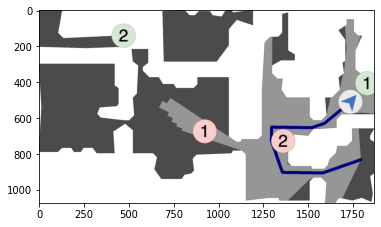

In [62]:
habitat.tasks.nav.nav.COLOR = 10
action_sequence = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,  0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 3]
step_sequence(action_sequence)

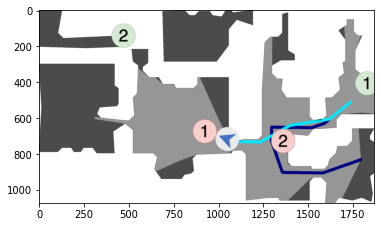

In [63]:
habitat.tasks.nav.nav.COLOR = 100
action_sequence = [1] * 17 + [0]*4 + [2]*3 + [0]*6 + [1]*2 + [0]*5 + [2]*3 + [0]*4 + [2]*2 + [0, 3] 
step_sequence(action_sequence)

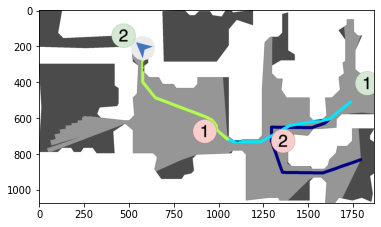

In [64]:
habitat.tasks.nav.nav.COLOR = 150

action_sequence = [2]*2 + [0]*2 + [1]*2 + [0]*12 + [2]*3 + [0]*3 + [2]*4 + [0]*5 + [1]* 5 + [3]
step_sequence(action_sequence)

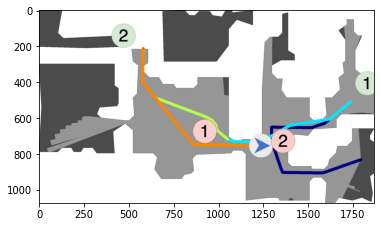

In [65]:
habitat.tasks.nav.nav.COLOR = 200
action_sequence = [1]*13 + [0]*5 + [1]*4 + [0]*12 + [1]*5 + [0]*10 +[3]
step_sequence(action_sequence)

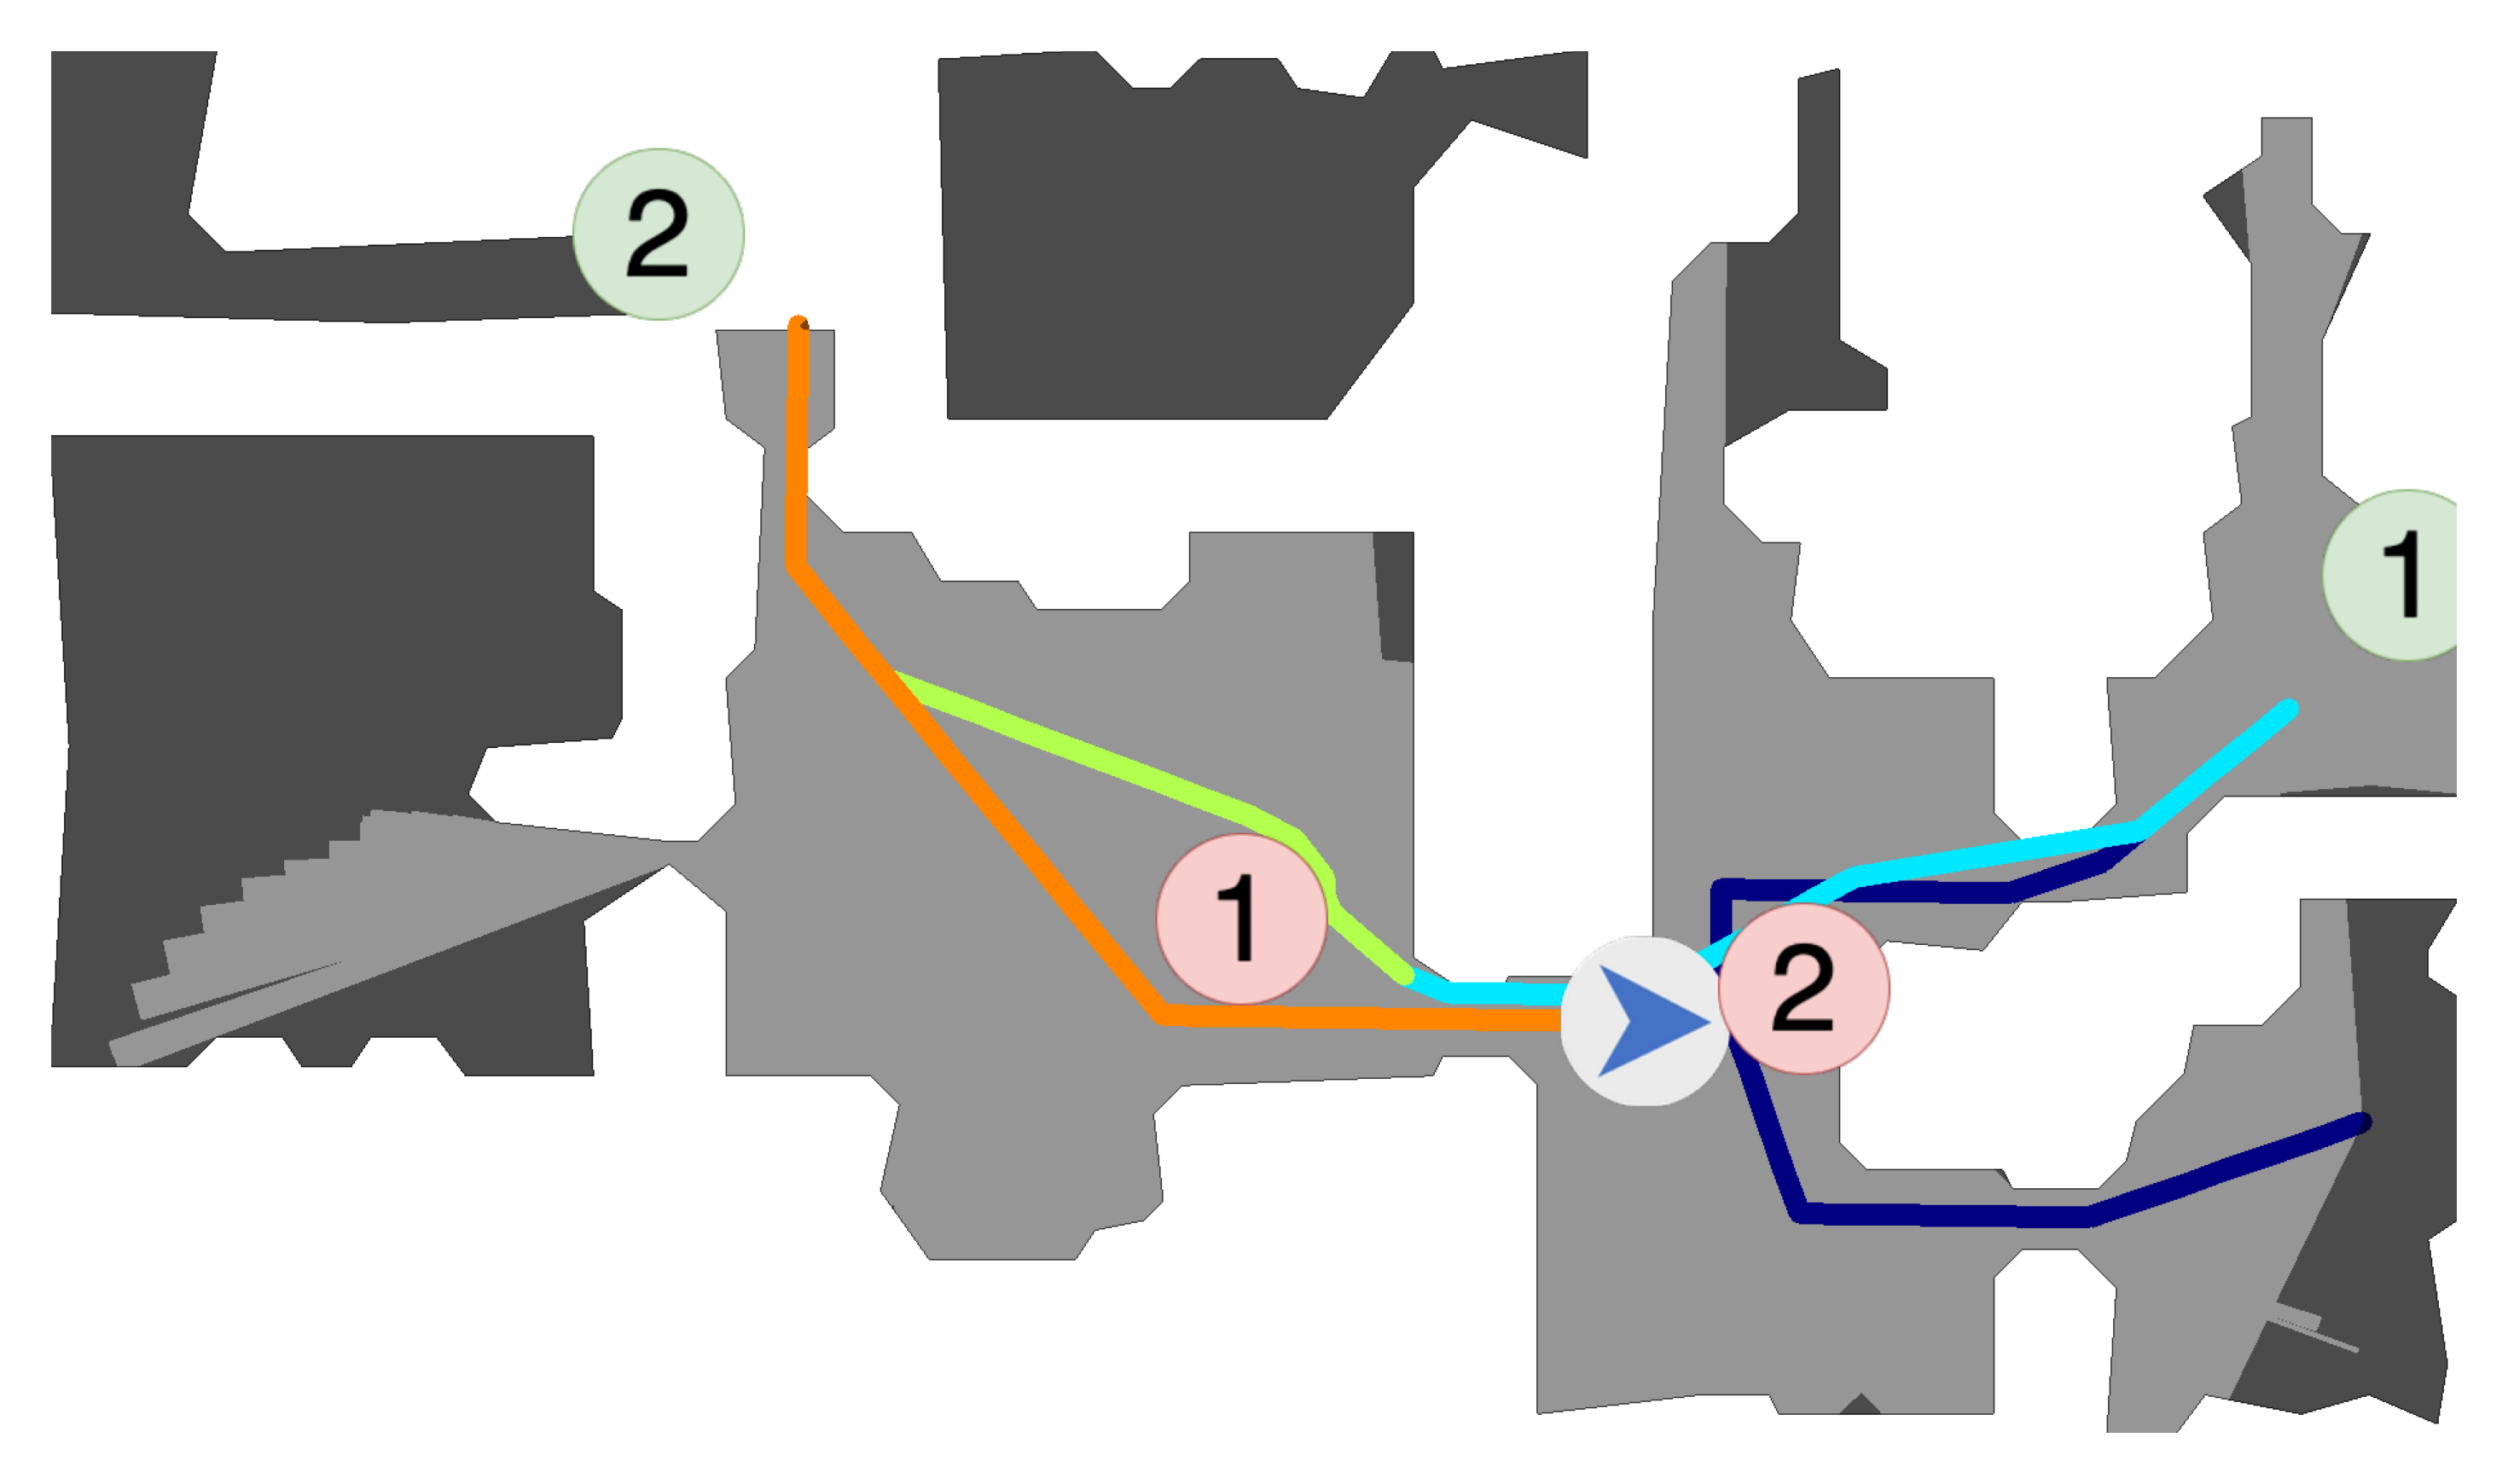

In [73]:
habitat.tasks.nav.nav.COLOR = 200
action_sequence = [1, 2]
step_sequence(action_sequence)

In [349]:
# FORWARD
obs, reward, done, metrics = env.step(action={'action': 0})
# print(obs['gripped_object_id'], reward, metrics)
cum_reward += sum([reward[key] for key, value in reward.items()])

In [321]:
# LEFT
obs, reward, done, metrics = env.step(action={'action': 1})
# print(obs['gripped_object_id'], reward, metrics)
cum_reward += sum([reward[key] for key, value in reward.items()])

In [248]:
# RIGHT
obs, reward, done, metrics = env.step(action={'action': 2})
cum_reward += sum([reward[key] for key, value in reward.items()])

In [351]:
# GRAB ACTION
obs, reward, done, metrics = env.step(action={'action': 3})
print(obs['gripped_object_id'], reward, metrics)
cum_reward += sum([reward[key] for key, value in reward.items()])

-1 {'agent_to_object_dist_reward': 0.0, 'object_to_goal_dist_reward': 0.0, 'gripped_success_reward': -0.1, 'drop_success_reward': 0.0, 'episode_success_reward': 2.5} {'object_distance_from_agent': {1: 0.8634788562851188, 0: 2.1805243383464874}, 'object_distance_to_goal': {1: 0.0811477360079221, 0: 0.059507708442969445}, 'collisions': {'count': 2, 'is_collision': False}, 'object_goals': {1: array([0.86203   , 0.13785595], dtype=float32), 2: array([2.179951 , 2.8837907], dtype=float32)}, 'top_down_map': {'map': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'agent_map_coord': (188, 309

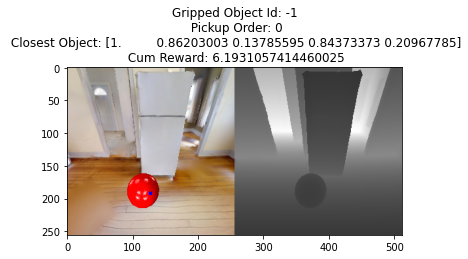

In [352]:
color_obs = obs["rgb"][:, :, :3]
color_obs[190:195, 125:130, :] = [0, 0, 255] 
depth_obs = obs["depth"]
depth_obs = ((depth_obs - np.min(depth_obs))/ np.max(depth_obs) * 255.0).astype(np.int)
depth_obs = np.stack([depth_obs]*3, axis=2)[:, :, :, 0]
plt.title(
    "Gripped Object Id: {}\n " \
    "Pickup Order: {}\n "\
    "Closest Object: {}\n "\
    "Cum Reward: {}".format(
        obs['gripped_object_id'], 
        '0',
        obs['next_object_pos_and_goal'],
        cum_reward)
)
plt.imshow(np.concatenate([color_obs, depth_obs], axis=1))

In [130]:
reward

{'agent_to_object_dist_reward': 0.0,
 'object_to_goal_dist_reward': 0.0,
 'gripped_success_reward': 0.0,
 'episode_success_reward': 0.0}

In [41]:
env.current_episode.goals

[SokobanSpec(bbox=None, position=[8.893550872802734, 0.03243936598300934, -0.054210782051086426], rotation=[0.0, 0.7681480050086975, 0.0, 0.640272319316864], info=None),
 SokobanSpec(bbox=None, position=[1.4150439500808716, 0.182439386844635, -3.282881498336792], rotation=[0.0, 0.7681480050086975, 0.0, 0.640272319316864], info=None),
 SokobanSpec(bbox=None, position=[8.645960807800293, 0.182439386844635, -2.569878101348877], rotation=[0.0, 0.7681480050086975, 0.0, 0.640272319316864], info=None)]

In [110]:
np.array([True, False]).astype(int) + np.array([True, True]).astype(int)

array([2, 1])